In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from gensim.models import LdaModel
import pandas as pd
import ecopy as ep
import pingouin as pg

/home/mashrekur/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mashrekur/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
nTopics = 45

In [3]:
topic_names = [
'Water Quality',
'Sediment Transport',
'Wastewater Treatment',
'Flood Risk & Assessment',
'Hydrogeology',
'Coastal Hydrology', 
'River Flow',
'Wetland & Ecology',
'Runoff Quality',
'Rainfall-Runoff',
'Urban Drainage',
'Systems Hydrology',
'Surface-GW Interactions',
'Irrigation Water Management',
'Drought & Water Scarcity',
'Climate Change Impacts',
'Gauging & Monitoring',
'Forecasting',
'Glaciology',
'Salinity',
'Peatlands Mapping & Monitoring',
'Spatial Variability',
'Land Surface Flux',
'Solute Transport',
'Water Resources Management',
'Numerical Modeling',
'Hydrochemistry',
'Pollutant Removal',
'Groundwater Recharge',
'Uncertainty',
'Land Cover',
'Modeling & Calibration',
'Soil Moisture',
'Water Storage & Budgeting',
'Aquifers & Abstraction',
'Microbiology',
'Streamflow',
'Erosion',
'Dynamic Processes',
'Temporal Variability',
'Spatial Variability of Precipitation',
'Rainfall Intensity & Measurement',
'Watershed Hydrology',
'Hydraulics',
'Quantitative Analysis',
]

In [4]:
# Define colors to associate with each topic
custom_colors = {
 'burlywood': '#DEB887',
 'chocolate': '#D2691E',
 'crimson': '#DC143C',
 'darkgreen': '#006400',
 'darkorange': '#FF8C00',
 'darkslategrey': '#2F4F4F',
 'deepskyblue': '#00BFFF',
 'dimgray': '#696969',
 'firebrick': '#B22222',
 'gold': '#FFD700',
 'goldenrod':'#DAA520',
 'lawngreen':'#7CFC00',
 'rosybrown':'#BC8F8F',
 'mediumslateblue':'#7B68EE',
 'mediumvioletred': '#C71585',
 'orangered': '#FF4500',
 'orchid': '#DA70D6',
 'royalblue': '#4169E1',
 'slateblue': '#6A5ACD',
 'springgreen': '#00FF7F',
 'steelblue': '#4682B4',
 'teal': '#008080',
 'turquoise': '#40E0D0',
 'chamoisee': '#A0785A',
 'blueviolet': '#8A2BE2',
 'yellowgreen': '#9ACD32',
 'cadmiumred': '#E30022',
 'royalblue': '#4169E1',
 'americanrose':  '#FF033E',
 'asparagus': '#87A96B',
 'coral':'#FF7F50',
 'magenta':'#FF00FF',
 'cadet':'#536872',
 'navy':'#000080',
 'bondiblue':'#0095B6',
 'blue':'#0000FF',
 'boysenberry':'#873260',
 'khaki':'#F0E68C',
 'cgblue':'#007AA5',
#  'linen':'#FAF0E6',
 'byzantine':'#BD33A4',
 'palevioletred':'#DB7093',
 'sienna':'#A0522D',
 'mediumspringgreen':'#00FA9A',
 'indianred':'#CD5C5C',
 'tomato': '#FF6347',
 'darkcyan': '#008B8B',
    
}

# turn into a list
colorlist = []
for i, color in enumerate(custom_colors.values()):
    colorlist.append(tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
    colorlist[i] = (colorlist[i][0] / 256, colorlist[i][1] / 256, colorlist[i][2] / 256)

# Load Data

In [5]:
# Load model
lda_model = LdaModel.load(f'trained_models/trained_lda_model_new_{nTopics}')

In [6]:
# Load topic distributions
topic_distributions = np.load(f'data/topic_distributions_broad_{lda_model.num_topics}.npy')

In [7]:
# Pull topics
topics = lda_model.show_topics(formatted=False, num_topics=nTopics, num_words=20)

In [8]:
# load raw corpus dataframe
with open('data/raw_corpus_broad.pkl', 'rb') as f:
    corpus_df = pkl.load(f)

/home/mashrekur/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/mashrekur/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [9]:
# Pull journals
journals = corpus_df.Journal.unique()
journals

array(['HESS', 'HP', 'HSJ', 'JH', 'JHM', 'WRR', 'AWR', 'HGJ', 'JAWRA',
       'JCH', 'JWRPM', 'WR', 'WRM', 'ESWRT', 'GW', 'ISWCR', 'JHREG',
       'WRI'], dtype=object)

In [10]:
# Pull years
years = np.unique(corpus_df['Year'])

# Corpus Complexity

In [11]:
def calc_entropy(pmf):
    return -np.nansum(pmf * np.log(pmf)) #code implementation of entropy equation

In [12]:
# Count per journal per year
journal_papers = np.full(len(journals), np.nan) #an array of nans with a len(journal)=6
for j, journal in enumerate(journals): #count for all journals
    journal_papers[j] = len(np.where(corpus_df['Journal'] == journal)[0]) #length of array of wherever the journal is true for a year 

In [13]:
# topic_distributions = np.where(topic_distributions == 0, 0.000000001, topic_distributions)

In [14]:
# topic_distributions

In [15]:
# eqn. 4
# calculate total entropy per journal
journal_entropy = np.full(len(journals), np.nan) 
journal_topic_popularity = np.full([len(journals), nTopics], np.nan) 
for j, journal in enumerate(journals): 
    jidx = np.where(corpus_df.Journal == journal)[0]      
    a = np.sum(topic_distributions[jidx,:], axis=0)
    b = np.sum(topic_distributions[jidx,:])
    journal_topic_popularity[j,:] = a/b  
    journal_entropy[j] = calc_entropy(journal_topic_popularity[j,:])

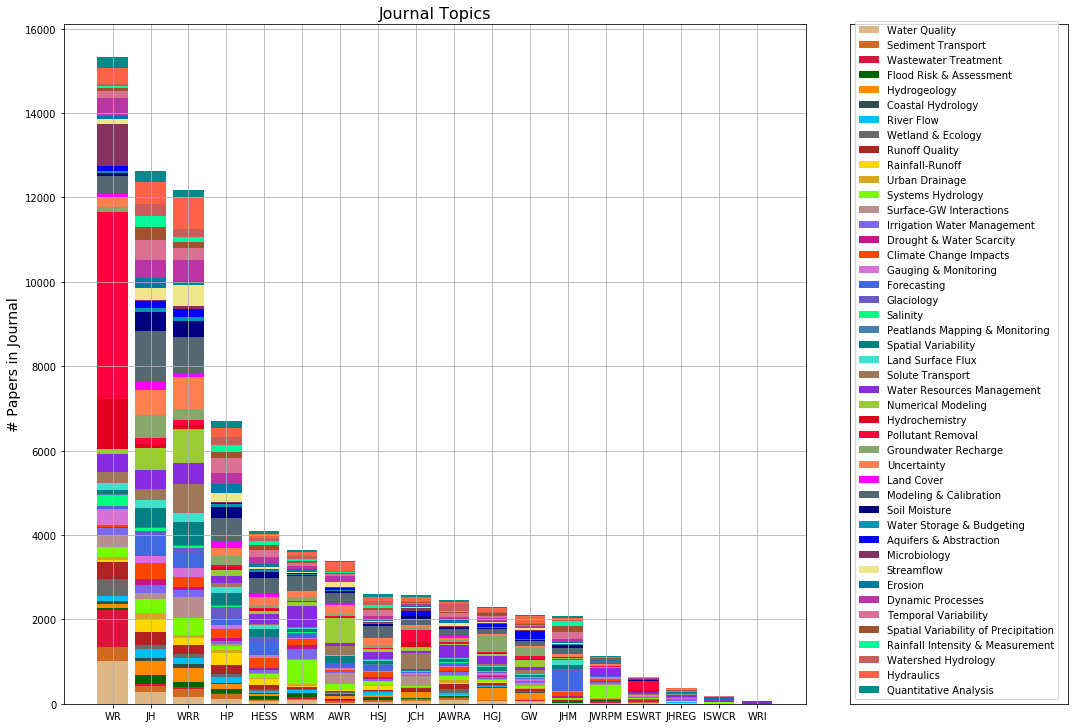

In [16]:
# plot total entropy per journal
fig = plt.figure(figsize=(18, 12.5))
gs = fig.add_gridspec(1,4)

sort_dex = np.argsort(-journal_papers)
plotdata = journal_topic_popularity * np.expand_dims(journal_papers,-1)

ax1 = fig.add_subplot(gs[0, :3])
for t in range(nTopics):
    if t == 0:
        ax1.bar(journals[sort_dex], plotdata[sort_dex, t],
               color=colorlist[t])
    else:
        ax1.bar(journals[sort_dex], plotdata[sort_dex, t],
               bottom=np.sum(plotdata[sort_dex, :t], axis=1),
               color=colorlist[t])

ax1.set_ylabel('# Papers in Journal', fontsize=14)
ax1.set_title(f'Journal Topics', fontsize=16)
ax1.grid()


ax0 = fig.add_subplot(gs[0, 3])
for t in range(nTopics):
    if t == 0:
        ax0.bar(journals[sort_dex], plotdata[sort_dex, t],
               color=colorlist[t])
    else:
        ax0.bar(journals[sort_dex], plotdata[sort_dex, t],
               bottom=np.sum(plotdata[sort_dex, :t], axis=1),
               color=colorlist[t])
ax0.legend(topic_names)
ax0.bar(journals[sort_dex], np.sum(plotdata[sort_dex, :], axis=1), color='w')
ax0.set_xticks([])
ax0.set_yticks([])

# Save figure
plt.savefig('figures/journal_topics_papers_broad.png')

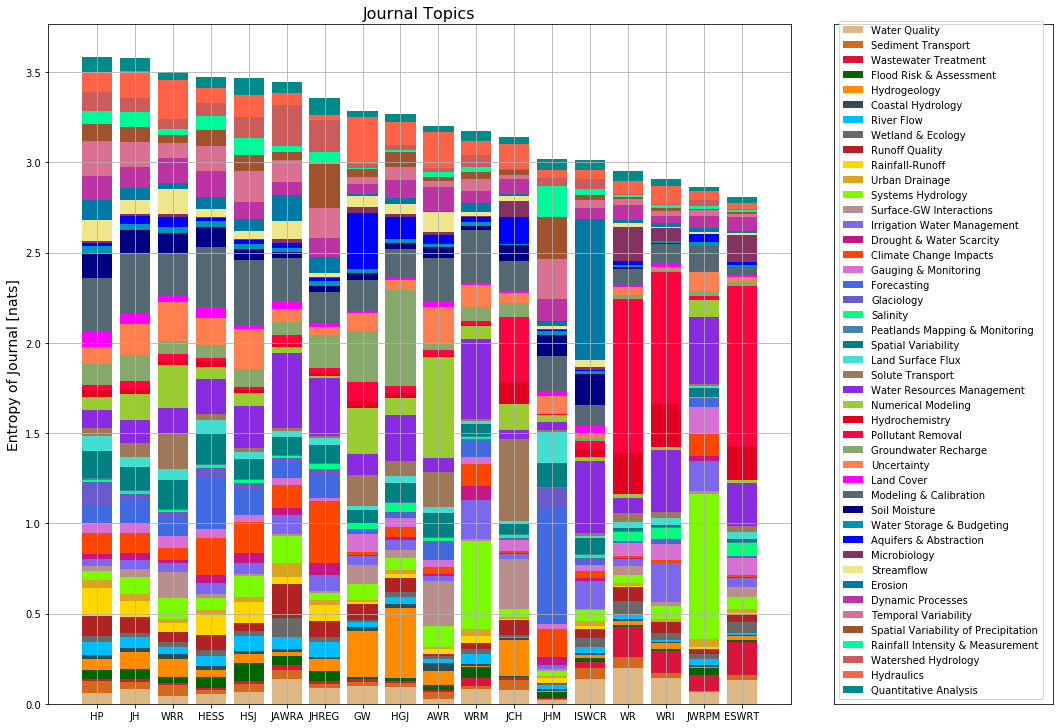

In [17]:
# plot total entropy per journal
fig = plt.figure(figsize=(18, 12.5))
gs = fig.add_gridspec(1,4)

sort_dex = np.argsort(-journal_entropy)
plotdata = journal_topic_popularity * np.expand_dims(journal_entropy,-1)
# plotdata = -journal_topic_popularity * np.log(journal_topic_popularity)

ax1 = fig.add_subplot(gs[0, :3])
for t in range(nTopics):
    if t == 0:
        ax1.bar(journals[sort_dex], plotdata[sort_dex, t],
               color=colorlist[t])
    else:
        ax1.bar(journals[sort_dex], plotdata[sort_dex, t],
               bottom=np.sum(plotdata[sort_dex, :t], axis=1),
               color=colorlist[t])

ax1.set_ylabel('Entropy of Journal [nats]', fontsize=14)
ax1.set_title(f'Journal Topics', fontsize=16)
ax1.grid()


ax0 = fig.add_subplot(gs[0, 3])
for t in range(nTopics):
    if t == 0:
        ax0.bar(journals[sort_dex], plotdata[sort_dex, t],
               color=colorlist[t])
    else:
        ax0.bar(journals[sort_dex], plotdata[sort_dex, t],
               bottom=np.sum(plotdata[sort_dex, :t], axis=1),
               color=colorlist[t])
ax0.legend(topic_names)
ax0.bar(journals[sort_dex], np.sum(plotdata[sort_dex, :], axis=1), color='w')
ax0.set_xticks([])
ax0.set_yticks([])

# Save figure
plt.savefig('figures/journal_topics_entropy_broad.png')

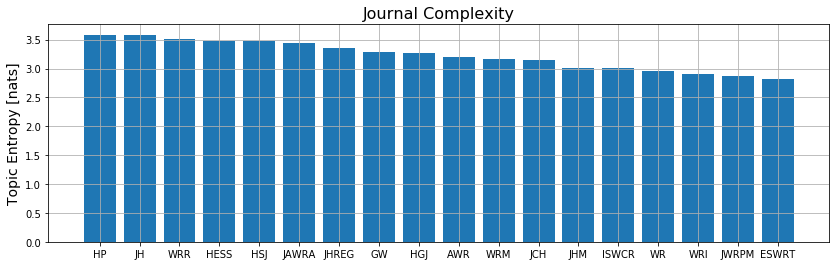

In [18]:
# plot total entropy per journal
fig, ax = plt.subplots(figsize=(14,4))
sort_dex = np.argsort(-journal_entropy)
plt.bar(journals[sort_dex], journal_entropy[sort_dex])
plt.ylabel('Topic Entropy [nats]', fontsize=14)
plt.title(f'Journal Complexity', fontsize=16)
# plt.ylim([2,3])
plt.grid()
plt.savefig('figures/journal_entropy_broad.png')

In [19]:
# calculate entropy of whole corpus
corpus_entropy = np.full(len(years), np.nan)
topic_popularity = np.full([len(years),nTopics], np.nan)

for y, year in enumerate(years):
    topic_distributions_year = topic_distributions[corpus_df['Year'] == year,:]
    topic_popularity[y,:] = np.sum(topic_distributions_year, axis=0) / np.sum(topic_distributions_year)
    corpus_entropy[y] = calc_entropy(topic_popularity[y])

/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [54]:
# calculate entropy of individual journals
journal_year_entropy = np.full([len(journals), len(years)], np.nan)
journal_year_topic_popularity = np.full([len(journals), len(years), nTopics], np.nan)
for y, year in enumerate(years):
    for j, journal in enumerate(journals):
        jyidx = np.where(np.logical_and((corpus_df.Journal == journal), (corpus_df.Year == year)))[0]        
        journal_year_topic_popularity[j,y,:] = np.sum(topic_distributions[jyidx,:], axis=0) / np.sum(topic_distributions[jyidx,:]) #per year per topic distribution/ per year all topic distribution
#         journal_year_topic_popularity[j,y,:] = np.where(journal_year_topic_popularity[j,y,:]==0, 1e-9, journal_year_topic_popularity[j,y,:])
        journal_year_entropy[j,y] = calc_entropy(journal_year_topic_popularity[j,y,:])

/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [21]:
#replace all nans with a very small value
# journal_year_topic_popularity = np.nan_to_num(journal_year_topic_popularity, copy=True, nan=0.000000001, posinf=None, neginf=None)
#replace all zeros with a very small value
journal_year_topic_popularity = np.where(journal_year_topic_popularity==0, 0.000000001, journal_year_topic_popularity)
journal_year_topic_popularity

array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [1.35037480e-02, 6.01156309e-03, 4.39939383e-03, ...,
         2.81350562e-02, 1.97801764e-02, 1.74419004e-02],
        [1.13332939e-02, 3.85822427e-03, 3.34631028e-03, ...,
         2.60831232e-02, 1.92235565e-02, 1.66759069e-02],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[2.95464564e-02, 4.05140190e-02, 4.70434425e-03, ...,
         1.14191032e-02, 3.57179019e-02, 1.00000000e-09],
        [2.58859006e-02, 3.72035306e-02, 2.02859425e-03, ...,
         2.29500236e-02, 2.41835755e-02, 1.50393205e-02],
        [2.95296492e-02, 

In [56]:
# journal_year_entropy = np.where(journal_year_entropy=='NaN', 0, journal_year_entropy)
journal_year_entropy[journal_year_entropy == 0] = 'nan'

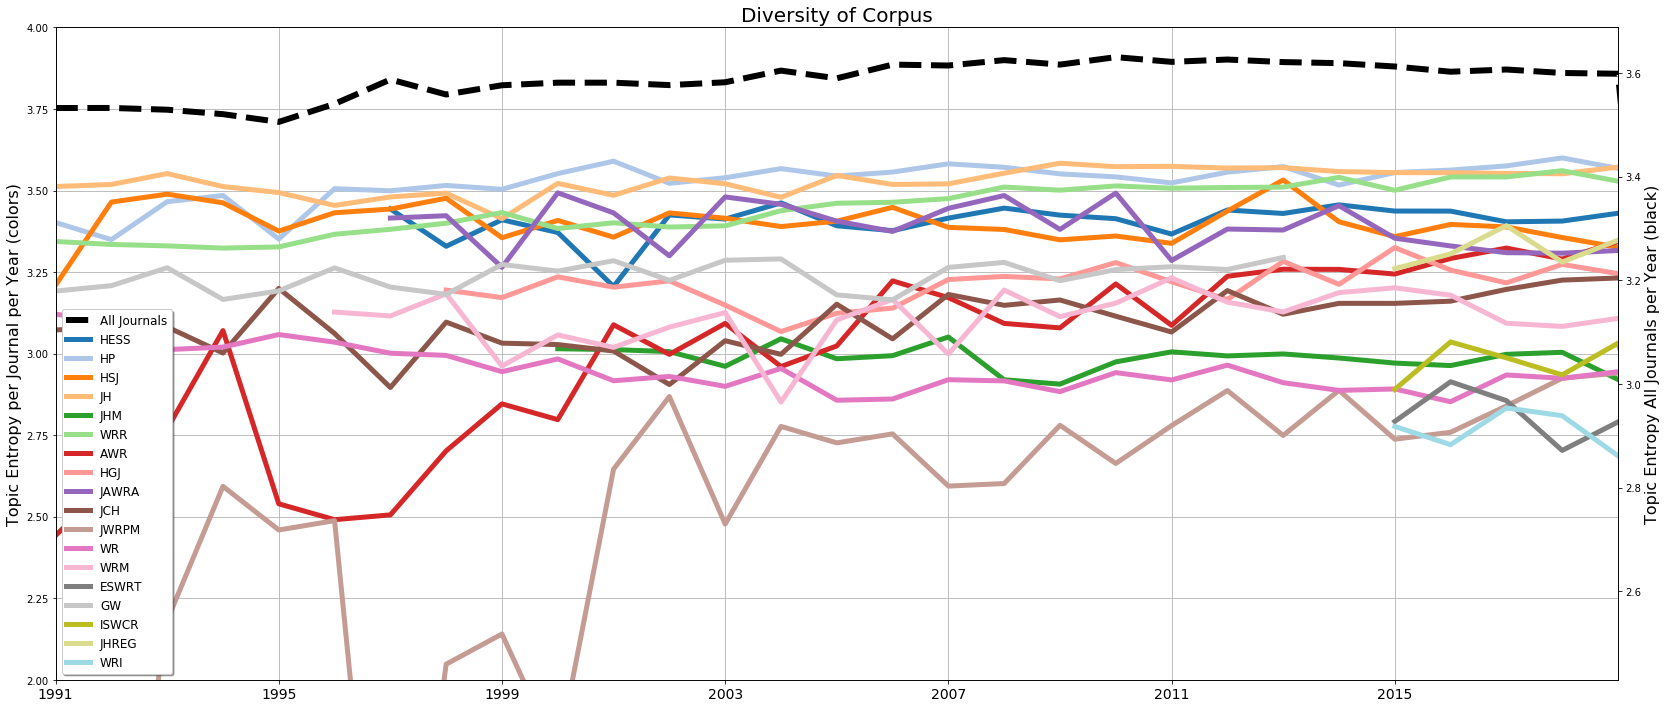

In [59]:
# Create corpus figure --- by year

# Init figures
fig, ax = plt.subplots(figsize=(28,12))

# set color cycle
colordexes = np.linspace(0,19,len(journals)).astype(int)
colors = list(plt.cm.tab20(np.arange(20)))
colors = [colors[i] for i in colordexes]
ax.set_prop_cycle('color', colors)

# Plot full corpus count by year
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
lines = ax2.plot(years, corpus_entropy, 
                 'k--', 
                 label=f'All Journals', 
                 linewidth = 6)  

# Plot each journal individually
for j, journal in enumerate(journals):
    linej = ax.plot(years, journal_year_entropy[j,:], 
                       linewidth = 5,
                       label=f'{journal}')
    lines = lines+linej
    
# Axis labels
ax.set_title(f'Diversity of Corpus', fontsize=20)
ax.set_ylabel('Topic Entropy per Journal per Year (colors)', fontsize=16)
ax2.set_ylabel('Topic Entropy All Journals per Year (black)', fontsize=16)
ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)
ax.set_xlim([0,years[-2]])
ax.set_ylim([2,4])

# Legend
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize=12, shadow=True, loc=3)

# Aesthetics    
ax.grid()

# Save figure
plt.savefig('figures/corpus_entropy_broad.png')

In [23]:
print(journals[1])

HP


In [24]:
# j = 15
# print(journals[j])
print('Corpus Entropy')
pg.corr((range(0,len(years),1)),corpus_entropy)

Corpus Entropy


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,30,-0.171348,"[-0.5, 0.2]",0.02936,-0.042539,0.365278,0.336,0.1489


In [25]:
#Understanding ecopy diversity
# A site *x* species matrix, where sites are rows and columns are species.
#test calculation of yearwise diversity
ep.diversity(journal_year_topic_popularity[:,8,:], method = 'simpson', breakNA=False, num_equiv=False)
# num_equiv: [True | False]
#                 Whether or not species diversity is returned in number-equivalents, which has better properties than raw diversity.
# Number equivalents are calculated as follows:

#                 *shannon*: :math:`exp(H)`

#                 *gini-simpson*: :math:`\frac{1}{1-D}`

#                 *simpson*: :math:`\frac{1}{D}`


array([0.04504245, 0.03829365, 0.05037416, 0.04465924, 0.        ,
       0.04230373, 0.10464982, 0.06948307, 0.06204866, 0.06963801,
       0.18706532, 0.10855937, 0.08855256, 0.        , 0.05146985,
       0.        , 0.        , 0.        ])

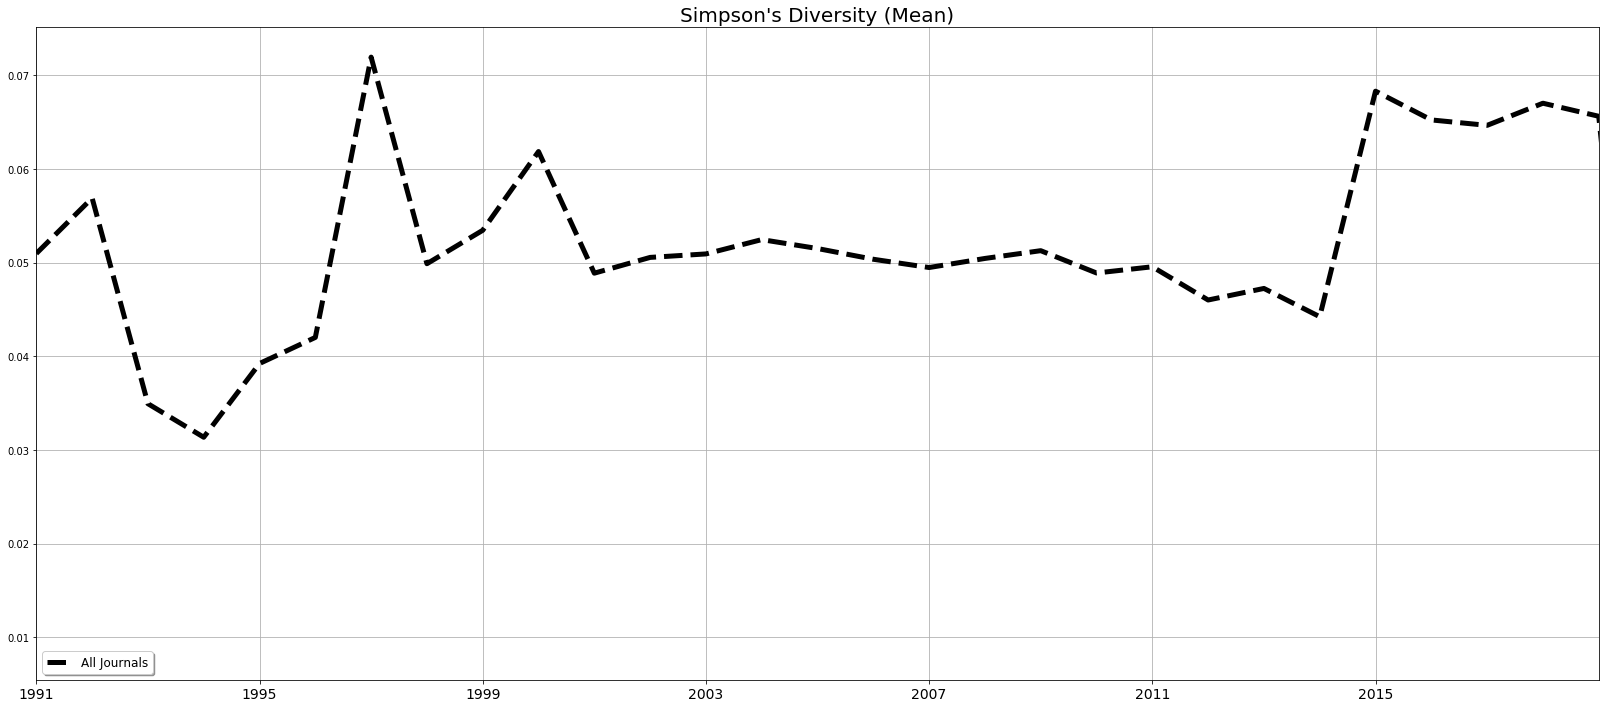

In [26]:
#calculate simpson diversity over entire corpus
corpus_simpson = np.full(30, np.nan)
#calculating mean simpson diversity over entire corpus for each year
for y in range(0,30,1):
    corpus_simpson[y] = np.mean(ep.diversity(journal_year_topic_popularity[:,y,:], method = 'simpson', breakNA=False, num_equiv=False))
#check the resultant array
corpus_simpson

#plotting simpson diversity over years
# Init figures
fig, ax = plt.subplots(figsize=(28,12))

# Plot full corpus count by year
lines = ax.plot(years, corpus_simpson, 
                 'k--', 
                 label=f'All Journals', 
                 linewidth = 5)  
    
# Axis labels
ax.set_title(f'Simpson\'s Diversity (Mean)', fontsize=20)
ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)
ax.set_xlim([0,years[-2]])
# ax.set_ylim([15,36])

# Legend
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize=12, shadow=True, loc=3)

# Aesthetics    
ax.grid()

# Save figure
plt.savefig('figures/corpus_simpson_broad.png')
    
    
    
    

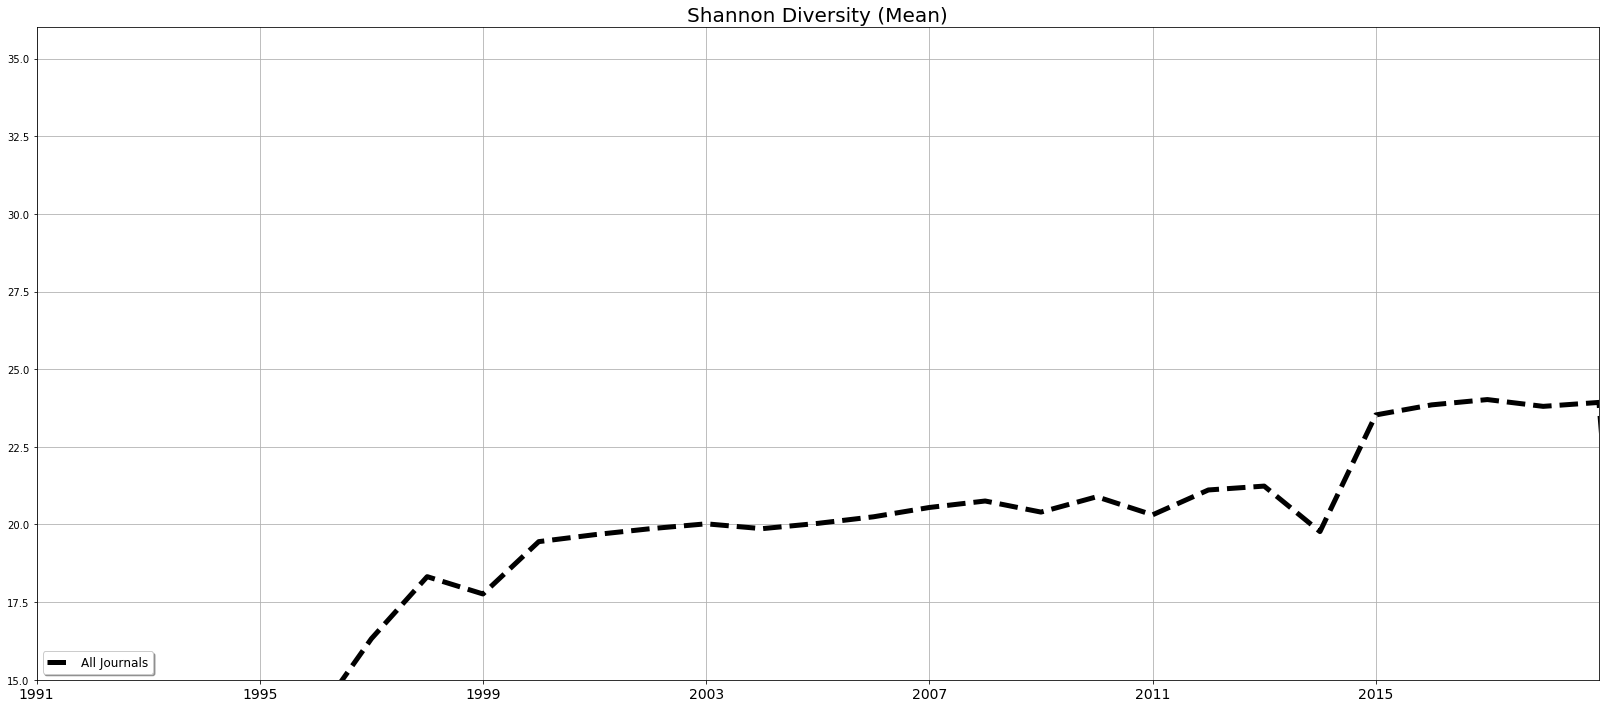

In [27]:
#calculate shannon diversity over entire corpus using ecopy
corpus_shannon = np.full(30, np.nan)
#calculating mean simpson diversity over entire corpus for each year
for y in range(0,30,1):
    corpus_shannon[y] = np.mean(ep.diversity(journal_year_topic_popularity[:,y,:], method = 'shannon', breakNA=False, num_equiv=True))
#check the resultant array
corpus_shannon

#plotting mean shannon diversity over years
# Init figures
fig, ax = plt.subplots(figsize=(28,12))

# Plot full corpus count by year
lines = ax.plot(years, corpus_shannon, 
                 'k--', 
                 label=f'All Journals', 
                 linewidth = 5)  
    
# Axis labels
ax.set_title(f'Shannon Diversity (Mean)', fontsize=20)
ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)
ax.set_xlim([0,years[-2]])
ax.set_ylim([15,36])

# Legend
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize=12, shadow=True, loc=3)

# Aesthetics    
ax.grid()

# Save figure
plt.savefig('figures/corpus_shannon_broad.png')


    

/home/mashrekur/anaconda3/lib/python3.7/site-packages/ecopy/diversity/diversity.py:93: RuntimeWarning: divide by zero encountered in true_divide
  div = 1./(1.-div)


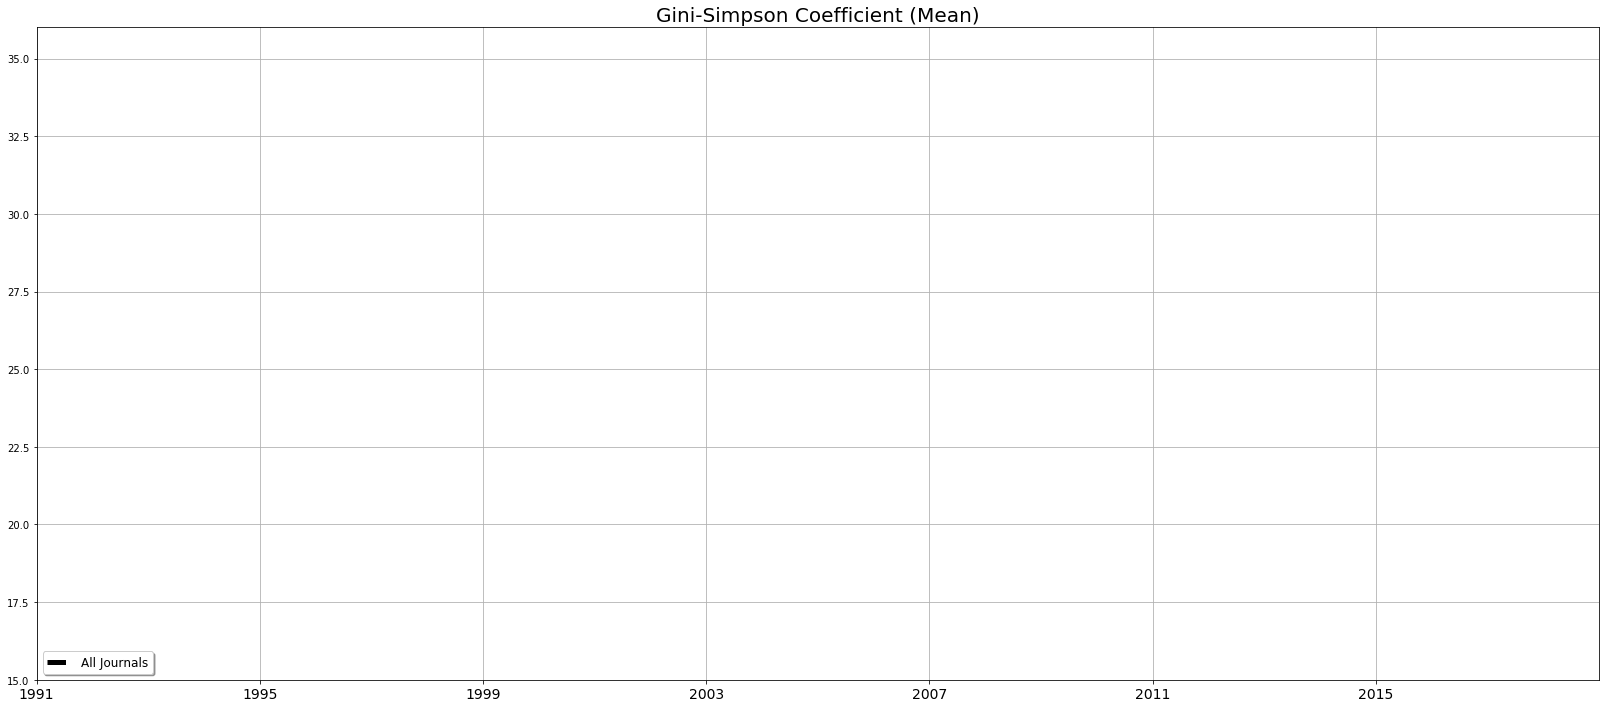

In [28]:
#calculate gini-simpson coefficient over entire corpus using ecopy
corpus_gini = np.full(30, np.nan)
#calculating mean simpson diversity over entire corpus for each year
for y in range(0,30,1):
    corpus_gini[y] = np.mean(ep.diversity(journal_year_topic_popularity[:,y,:], method = 'gini-simpson', breakNA=False, num_equiv=True))
#check the resultant array
corpus_gini

#plotting mean shannon diversity over years
# Init figures
fig, ax = plt.subplots(figsize=(28,12))

# Plot full corpus count by year
lines = ax.plot(years, corpus_gini, 
                 'k--', 
                 label=f'All Journals', 
                 linewidth = 5)  
    
# Axis labels
ax.set_title(f'Gini-Simpson Coefficient (Mean)', fontsize=20)
ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)
ax.set_xlim([0,years[-2]])
ax.set_ylim([15,36])

# Legend
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize=12, shadow=True, loc=3)

# Aesthetics    
ax.grid()

# Save figure
plt.savefig('figures/corpus_gini_simp_broad.png')

/home/mashrekur/anaconda3/lib/python3.7/site-packages/ecopy/diversity/diversity.py:147: RuntimeWarning: divide by zero encountered in log
  return H/np.log(n)


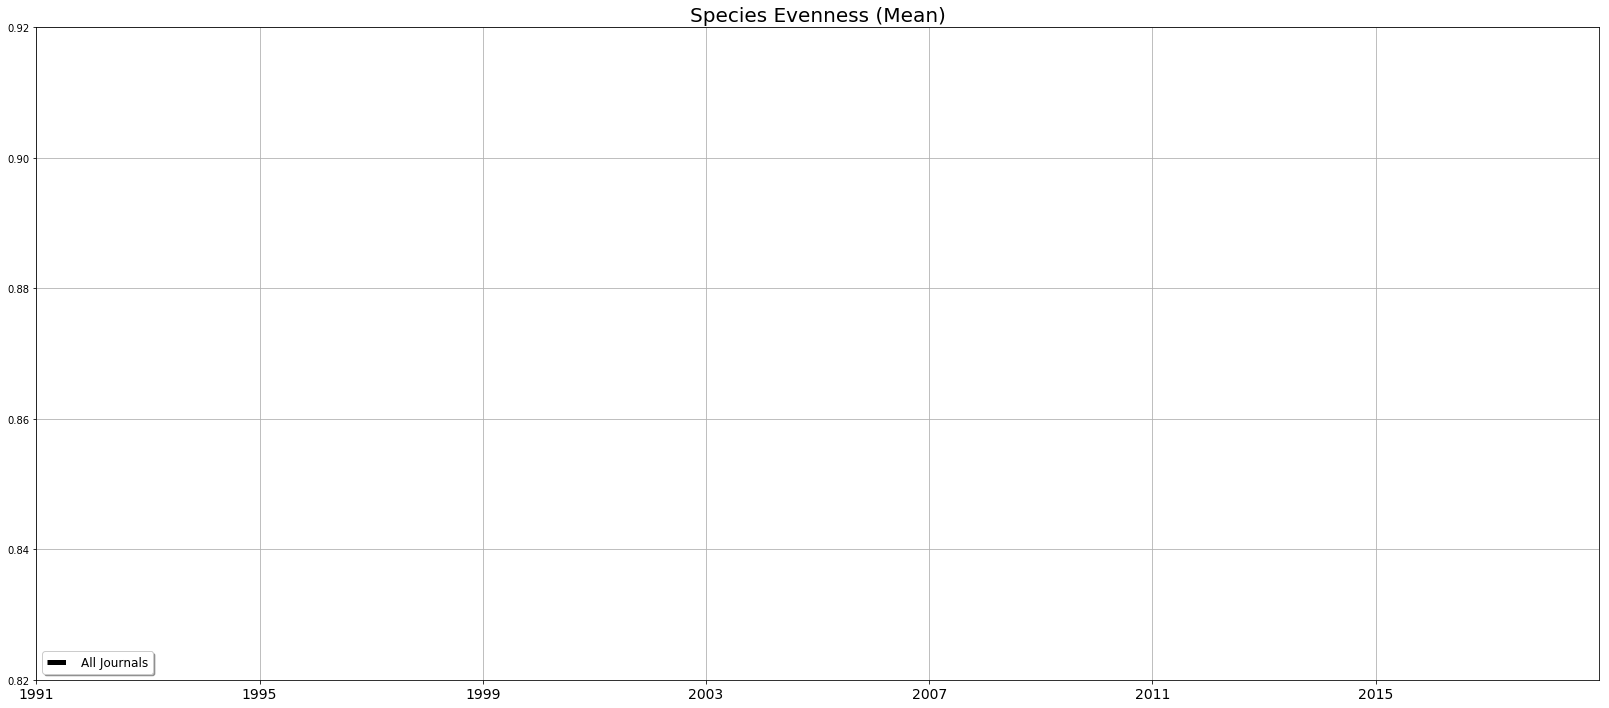

In [29]:
#calculate topic evenness over entire corpus using ecopy
# Evenness of a site. Shannon’s H divided by log of topics richness.
corpus_even = np.full(30, np.nan)
#calculating mean simpson diversity over entire corpus for each year
for y in range(0,30,1):
    corpus_even[y] = np.mean(ep.diversity(journal_year_topic_popularity[:,y,:], method = 'even', breakNA=False, num_equiv=True))
#check the resultant array
corpus_even

#plotting mean shannon diversity over years
# Init figures
fig, ax = plt.subplots(figsize=(28,12))

# Plot full corpus count by year
lines = ax.plot(years, corpus_even, 
                 'k--', 
                 label=f'All Journals', 
                 linewidth = 5)  
    
# Axis labels
ax.set_title(f'Species Evenness (Mean)', fontsize=20)
ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)
ax.set_xlim([0,years[-2]])
ax.set_ylim([0.82,0.92])

# Legend
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize=12, shadow=True, loc=3)

# Aesthetics    
ax.grid()

# Save figure
plt.savefig('figures/corpus_evenness_broad.png')



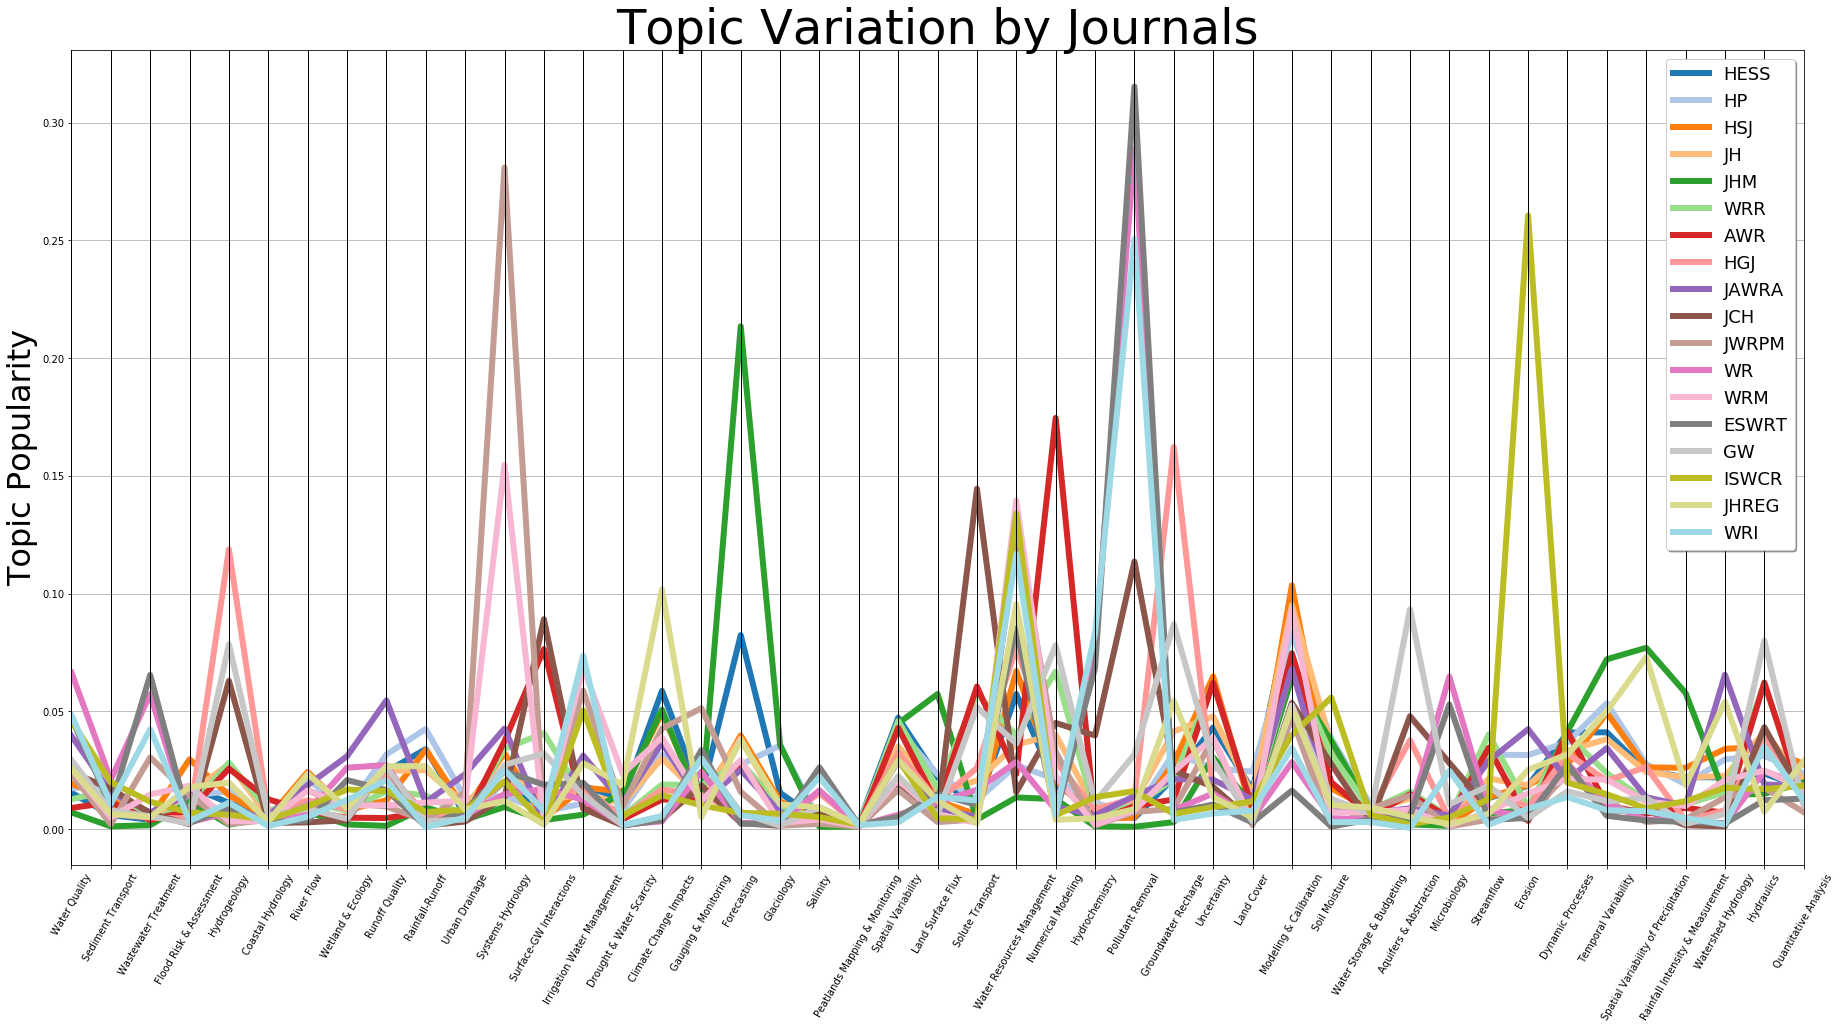

In [30]:
#parallel coordinates plot

#create dataframe of index, columns and data
plotdata = journal_topic_popularity #* np.expand_dims(journal_papers,-1)
df_plotdata = pd.DataFrame(index = journals, columns = topic_names, data = plotdata)
df_plotdata.index.name = "journals"
df_plotdata = df_plotdata.reset_index()

#plot figure
fig = plt.figure(figsize=(42,15))
gs = fig.add_gridspec(1,4)
ax = fig.add_subplot(gs[0, :3])

# set color cycle
colordexes = np.linspace(0,19,len(journals)).astype(int)
colors = list(plt.cm.tab20(np.arange(20)))
colors = [colors[i] for i in colordexes]
ax.set_prop_cycle('color', colors)

#define axes to plot without legend
pd.plotting.parallel_coordinates(df_plotdata, "journals", ax = ax, color = colors,
                                axvlines = 'Yes', linewidth = 6)
ax.get_legend().remove()
ax.set_title('Topic Variation by Journals', fontsize = 48)
ax.set_ylabel('Topic Popularity', fontsize = 32)
ax.tick_params(rotation=60, axis = 'x')
ax.legend(journals, loc='upper right', shadow=True, prop={'size': 18})


# plt.show()
# Save figure
plt.savefig('figures/parallel_coordinate_absolute_topics_broad.png')

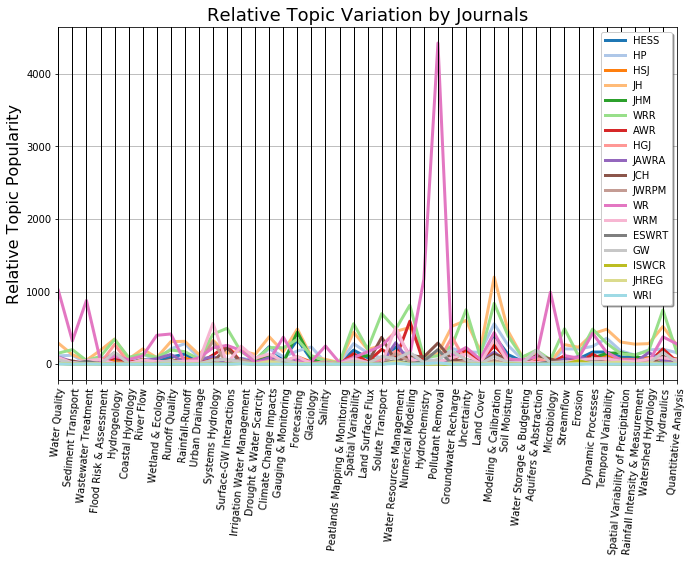

In [31]:
#Relative coordinates

#create dataframe of index, columns and data
plotdata = journal_topic_popularity * np.expand_dims(journal_papers,-1)
df_plotdata = pd.DataFrame(index = journals, columns = topic_names, data = plotdata)
df_plotdata.index.name = "journals"
df_plotdata = df_plotdata.reset_index()

#plot figure
fig = plt.figure(figsize=(15,6.5))
gs = fig.add_gridspec(1,4)
ax = fig.add_subplot(gs[0, :3])

# set color cycle
colordexes = np.linspace(0,19,len(journals)).astype(int)
colors = list(plt.cm.tab20(np.arange(20)))
colors = [colors[i] for i in colordexes]
ax.set_prop_cycle('color', colors)

#define axes to plot without legend
pd.plotting.parallel_coordinates(df_plotdata, "journals", ax = ax, color = colors,
                                axvlines = 'Yes', linewidth = 3)
ax.get_legend().remove()
ax.set_title('Relative Topic Variation by Journals', fontsize = 18)
ax.set_ylabel('Relative Topic Popularity', fontsize = 16)
ax.tick_params(rotation=85, axis = 'x')
ax.legend(journals, loc='upper right', shadow=True)


# plt.show()
# Save figure
plt.savefig('figures/parallel_coordinate_relative_topics_broad.png')

In [32]:
df_plotdata

,journals,Water Quality,Sediment Transport,Wastewater Treatment,Flood Risk & Assessment,Hydrogeology,Coastal Hydrology,River Flow,Wetland & Ecology,Runoff Quality,...,Microbiology,Streamflow,Erosion,Dynamic Processes,Temporal Variability,Spatial Variability of Precipitation,Rainfall Intensity & Measurement,Watershed Hydrology,Hydraulics,Quantitative Analysis
0,HESS,63.181538,24.287046,15.917044,73.604122,45.594405,22.155873,67.758121,37.403402,99.919967,...,9.979450,53.852711,75.285433,168.083952,168.643998,101.193396,90.288551,90.122543,96.609174,72.189832
1,HP,115.813324,123.612932,19.621183,94.218849,107.291174,41.854771,140.200847,57.168635,211.823227,...,22.573636,211.359814,210.227827,246.702461,357.713155,184.334938,127.125090,197.939475,207.989020,158.527120
2,HSJ,50.070144,32.186731,11.798508,76.887391,37.383763,11.967185,63.038049,20.722151,31.683892,...,4.529992,34.877422,48.410006,71.004474,128.103583,67.952279,67.474607,88.294736,91.143706,71.437153
3,JH,290.373103,132.444206,55.917416,192.798398,347.747713,71.238652,210.855161,90.517868,311.515708,...,37.410148,270.359622,234.330421,419.803738,482.489545,306.134241,276.975600,284.096882,518.878738,262.049001
4,JHM,14.542261,2.341239,3.300003,24.104368,3.797521,9.942569,14.896223,4.007044,2.721172,...,2.659057,13.642053,16.903208,85.730826,149.359307,159.492551,119.752542,29.947872,30.916834,41.082581
5,WRR,153.057173,201.528412,50.553306,108.544443,342.757596,95.283704,139.628141,94.913751,195.717097,...,62.376724,489.204371,113.454749,483.816961,288.810560,146.242420,126.838776,189.511711,748.123477,158.377405
6,AWR,30.314134,38.344361,12.827727,26.417905,87.055930,42.818782,25.371567,16.242147,15.745890,...,16.216640,117.084122,11.656081,140.467325,34.335085,22.270922,30.310312,23.423739,211.204754,36.909120
7,HGJ,64.595411,14.620963,11.096003,10.221959,272.977520,14.981086,28.075945,19.302991,55.217285,...,10.024191,39.829672,21.088780,73.559019,47.029739,60.573217,7.991542,18.234219,91.624959,30.703350
8,JAWRA,97.283987,38.175946,17.311805,36.321013,14.055674,14.478898,45.709299,75.989465,134.433890,...,14.190674,71.247750,104.304384,51.541094,84.631961,33.190427,24.137699,161.217089,46.521321,44.967113
9,JCH,61.789314,43.925224,17.060785,5.206593,161.621833,6.378432,7.247108,9.556759,68.224277,...,72.016274,22.089328,9.845286,64.938393,19.930109,20.270562,4.066812,2.843095,111.001053,35.472863


In [33]:
journal_papers

array([ 4106.,  6694.,  2598., 12636.,  2072., 12170.,  3395.,  2298.,
        2461.,  2568.,  1123., 15336.,  3647.,   641.,  2093.,   189.,
         376.,    76.])

# Journal Uniqueness

In [34]:
def calc_KL_divergence(pmf1,pmf2):
    div = pmf1 * np.log(pmf2/pmf1)
#     div[pmf1 == 0] = 0
#     div[pmf2 == 0] = 0
    return -np.nansum(div)

In [35]:
def jensen_shannon_divergence(pmf1,pmf2):
    M=0.5*(pmf1+pmf2)
    D1=calc_KL_divergence(pmf1,M)
    D2=calc_KL_divergence(pmf2,M)
    JSDiv = 0.5*D1+0.5*D2
    return JSDiv

In [36]:
def jensen_shannon_distance(pmf1,pmf2):
    M=0.5*(pmf1+pmf2)
    D1=calc_KL_divergence(pmf1,M)
    D2=calc_KL_divergence(pmf2,M)
    JSDiv = 0.5*D1+0.5*D2
    JSD = np.sqrt(JSDiv)
    return JSD

In [37]:
# calculate JSD 
JSD_journals = np.full([len(journals), len(years)], np.nan)
for y, year in enumerate(years):
    for j, journal in enumerate(journals):
        JSD_journals[j,y] = jensen_shannon_distance(journal_year_topic_popularity[j,y,:],
                                                     topic_popularity[y,:])

/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [38]:
# calculate KLD 
# KLD_journals = np.full([len(journals), len(years)], np.nan)
# for y, year in enumerate(years):
#     for j, journal in enumerate(journals):
#         KLD_journals[j,y] = calc_KL_divergence(journal_year_topic_popularity[j,y,:],
#                                                      topic_popularity[y,:])

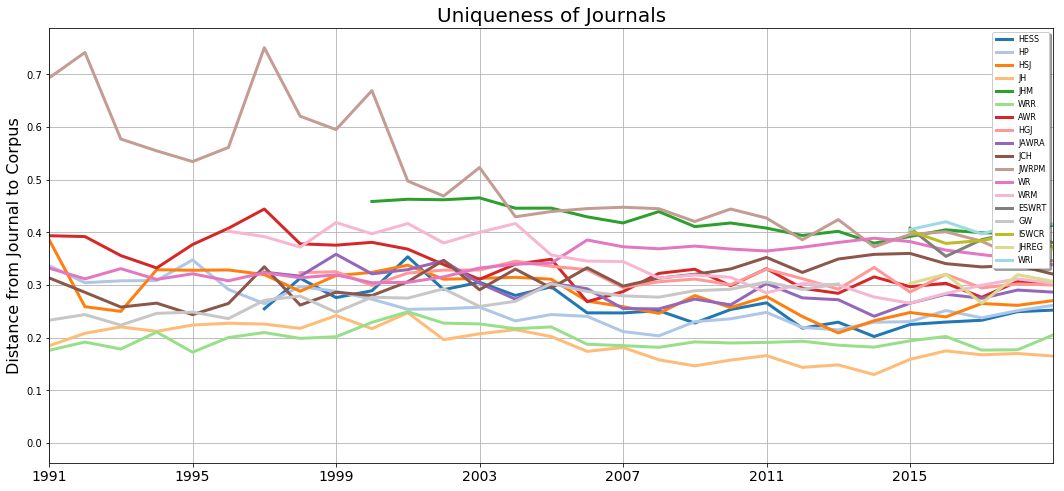

In [39]:
fig, ax = plt.subplots(1,1,figsize=(18,8))

# set color cycle
colordexes = np.linspace(0,19,len(journals)).astype(int)
colors = list(plt.cm.tab20(np.arange(20)))
colors = [colors[i] for i in colordexes]

plotdata = JSD_journals.transpose()
plotdata[plotdata==0] = np.nan

ax.set_prop_cycle('color', colors)
ax.plot(years, plotdata, lw=3)

# aesthetics
ax.legend(journals, shadow=True, loc=1, prop={'size': 8})
ax.set_title(f'Uniqueness of Journals', fontsize=20)
ax.set_ylabel('Distance from Journal to Corpus', fontsize=16)
ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)
ax.set_xlim([0,years[-2]])
plt.grid()

# Save figure
plt.savefig('figures/journal_uniqueness_broad.png')

# Journal Diversity

In [40]:
# calculate JSD 
JSD_across_journals = np.full([len(journals), len(journals), len(years)], np.nan)
for y, year in enumerate(years):
    for j1, journal1 in enumerate(journals):
        for j2, journal2 in enumerate(journals):
            JSD_across_journals[j1,j2,y] = jensen_shannon_distance(journal_year_topic_popularity[j1,y,:],
                                                                   journal_year_topic_popularity[j2,y,:])

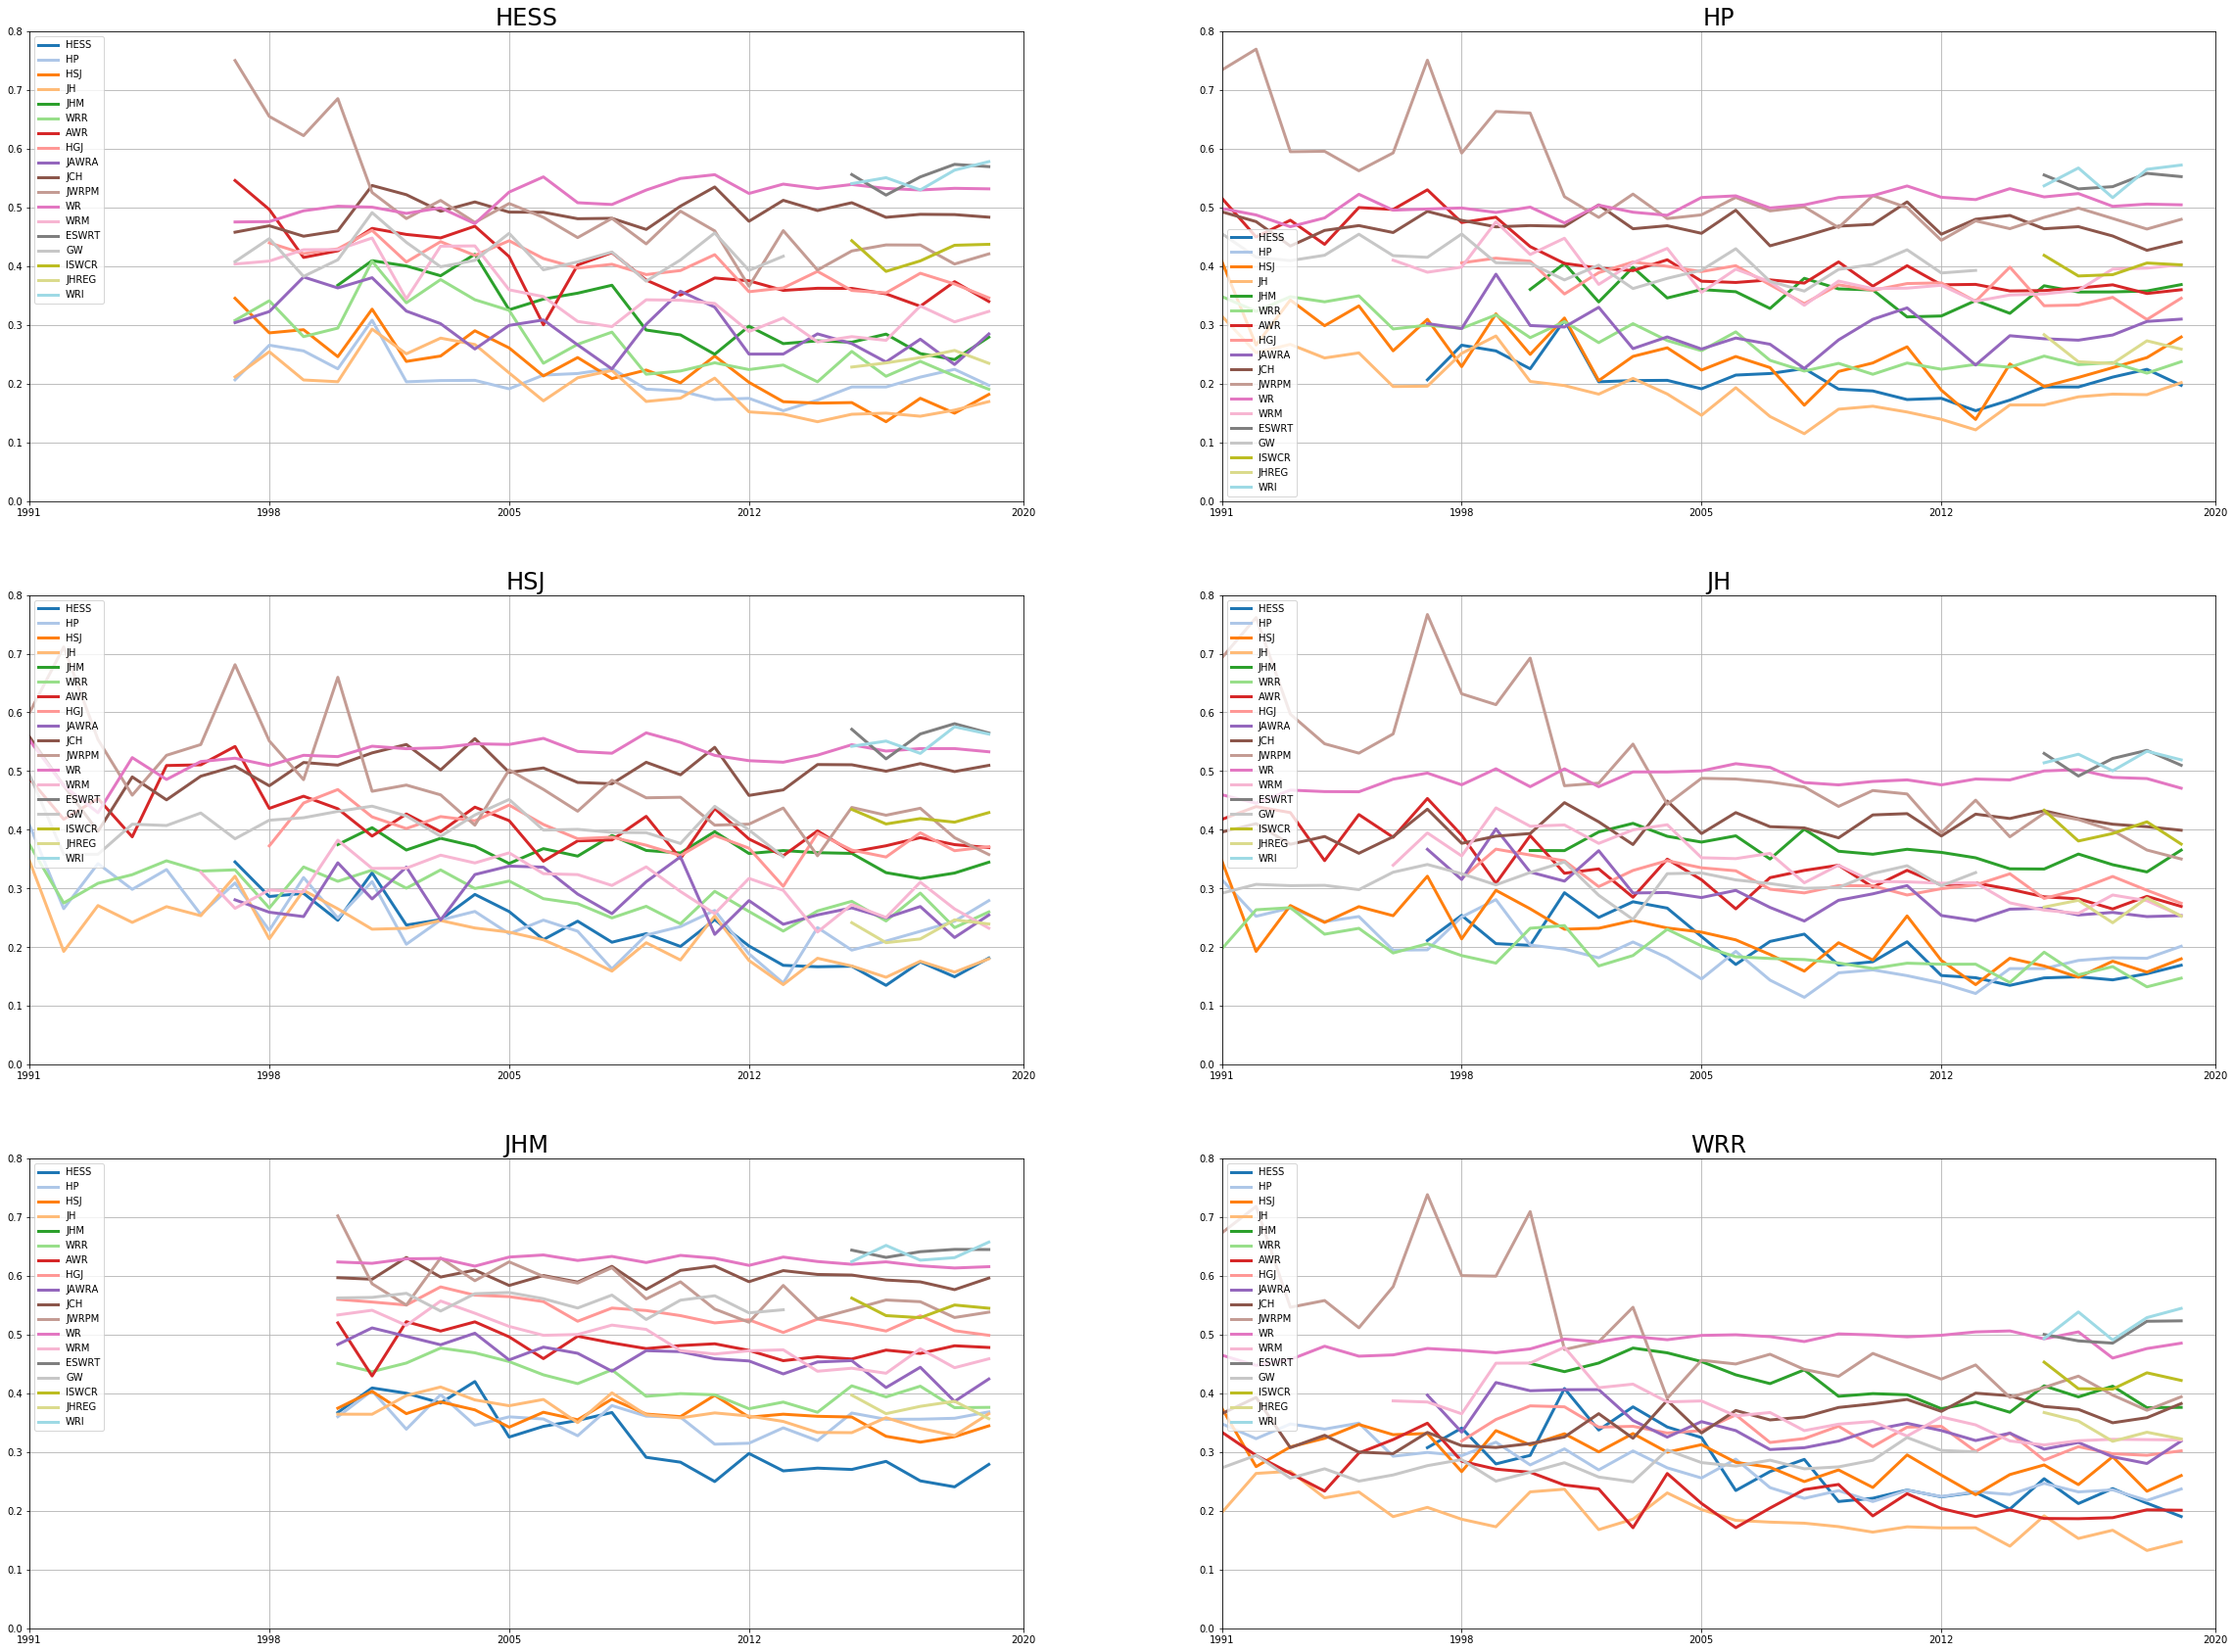

In [41]:
# plot JSD for each journal 
fig, axes = plt.subplots(3,2,figsize=(40,30))

# set color cycle
colordexes = np.linspace(0,19,len(journals)).astype(int)
colors = list(plt.cm.tab20(np.arange(20)))
colors = [colors[i] for i in colordexes]

for i, ax in enumerate(axes.flatten()):
    if i < len(journals):
        ax.set_prop_cycle('color', colors)
        plotdata = JSD_across_journals[i,:,:].transpose()
        plotdata[plotdata==0] = np.nan
        ax.plot(np.sort(years), JSD_across_journals[i,:,:].transpose(), linewidth=3)
        ax.set_title(journals[i], fontsize=24)
        ax.set_ylim([0.0, 0.8])
        ax.set_xlim([0, 27])
        ax.set_xticks(np.floor(np.linspace(0,len(years)-1,5)))
        ax.legend(journals)
        ax.grid() 
        
# Save figure
plt.savefig('figures/journal_time_jsd_broad.png')

In [42]:
#calculate JSD over whole corpus
JSD_corpus = np.full([len(journals), len(journals)], np.nan)
for j1, journal1 in enumerate(journals):
    for j2, journal2 in enumerate(journals):
        JSD_corpus[j1,j2] = jensen_shannon_distance(journal_year_topic_popularity[j1,:],
                                                    journal_year_topic_popularity[j2,:])

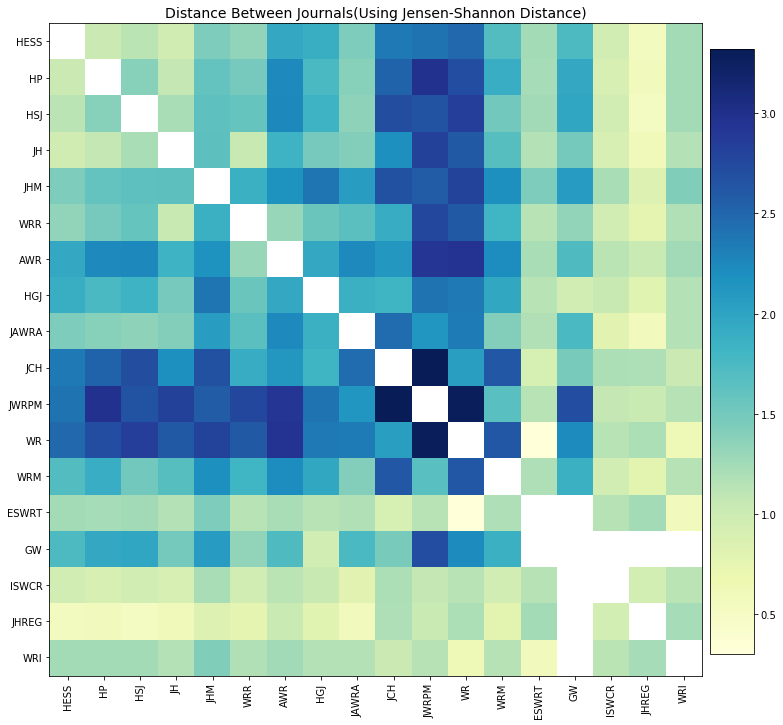

In [43]:
#plot single confusion matrix for JSD

fig, ax = plt.subplots(1,1, figsize=(12,12))

plot_data = JSD_corpus
plot_data[plot_data == 0] = np.nan
conf_arr_corpus = np.array(plot_data)    
res = ax.imshow(np.array(conf_arr_corpus), cmap="YlGnBu", interpolation='nearest')
width = len(journals)
height = len(journals)
ax.set_xticks(range(width))
ax.set_yticks(range(height))
ax.set_xticklabels(journals, rotation=90)
ax.set_yticklabels(journals)
ax.set_title('Distance Between Journals(Using Jensen-Shannon Distance)', fontsize=14)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(res, cax=cbar_ax)

# Save figure
plt.savefig('figures/journal_jsd_broad.png')

In [44]:
#calculate KLD over whole corpus
KLD_corpus = np.full([len(journals), len(journals)], np.nan)
for j1, journal1 in enumerate(journals):
    for j2, journal2 in enumerate(journals):
        KLD_corpus[j1,j2] = calc_KL_divergence(journal_year_topic_popularity[j1,:],
                                                    journal_year_topic_popularity[j2,:])

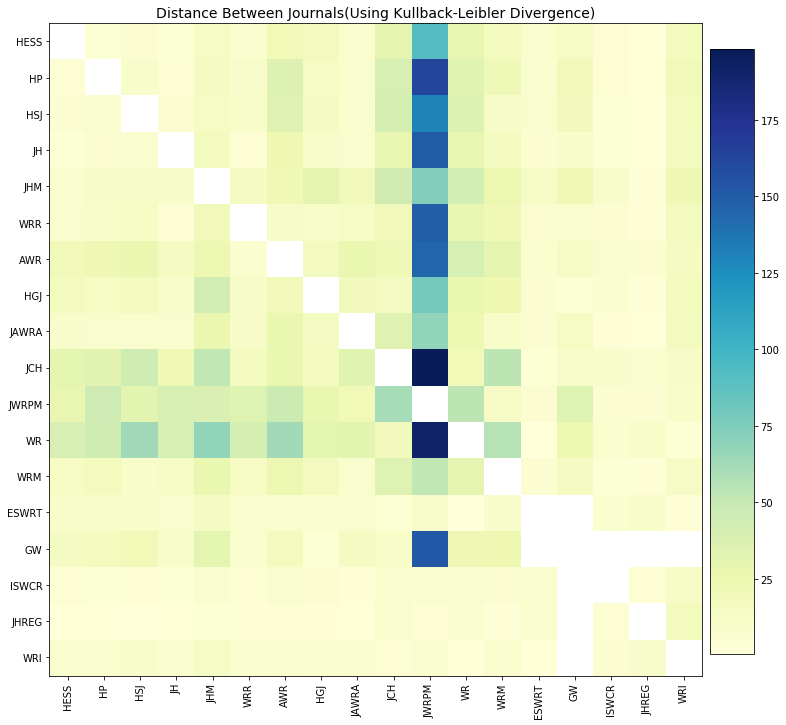

In [45]:
#plot single confusion matrix for KLD
fig, ax = plt.subplots(1,1, figsize=(12,12))

plot_data = KLD_corpus
plot_data[plot_data == 0] = np.nan
conf_arr_corpus = np.array(plot_data)    
res = ax.imshow(np.array(conf_arr_corpus), cmap="YlGnBu", interpolation='nearest')
width = len(journals)
height = len(journals)
ax.set_xticks(range(width))
ax.set_yticks(range(height))
ax.set_xticklabels(journals, rotation=90)
ax.set_yticklabels(journals)
ax.set_title('Distance Between Journals(Using Kullback-Leibler Divergence)', fontsize=14)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(res, cax=cbar_ax)

# Save figure
plt.savefig('figures/journal_kld_broad.png')

In [46]:
#calculate JSDiv over whole corpus
JSDiv_corpus = np.full([len(journals), len(journals)], np.nan)
for j1, journal1 in enumerate(journals):
    for j2, journal2 in enumerate(journals):
        JSDiv_corpus[j1,j2] = jensen_shannon_divergence(journal_year_topic_popularity[j1,:],
                                                    journal_year_topic_popularity[j2,:])

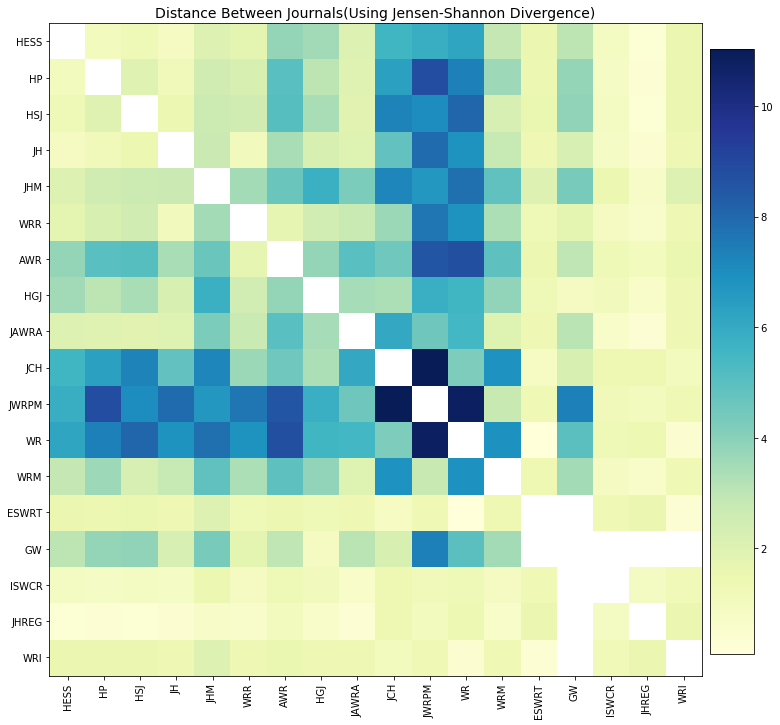

In [47]:
#plot single confusion matrix for JSDiv

fig, ax = plt.subplots(1,1, figsize=(12,12))

plot_data = JSDiv_corpus
plot_data[plot_data == 0] = np.nan
conf_arr_corpus = np.array(plot_data)    
res = ax.imshow(np.array(conf_arr_corpus), cmap="YlGnBu", interpolation='nearest')
width = len(journals)
height = len(journals)
ax.set_xticks(range(width))
ax.set_yticks(range(height))
ax.set_xticklabels(journals, rotation=90)
ax.set_yticklabels(journals)
ax.set_title('Distance Between Journals(Using Jensen-Shannon Divergence)', fontsize=14)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(res, cax=cbar_ax)

# Save figure
plt.savefig('figures/journal_jsdiv_broad.png')